In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kalman import TVPKalman, create_discounted_kalman, create_fls_kalman

np.random.seed(7)
print('Loaded. Numpy version:', np.__version__)


Loaded. Numpy version: 2.2.6


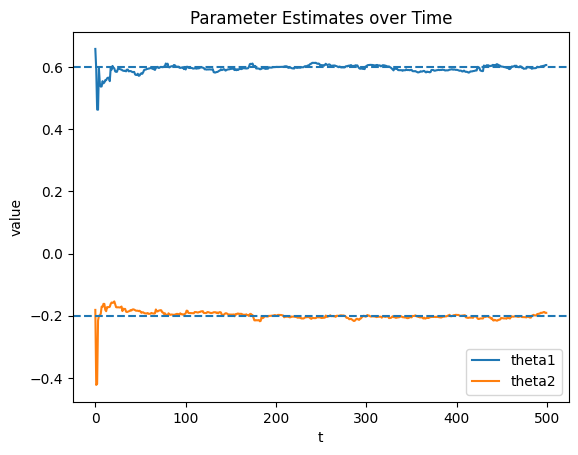

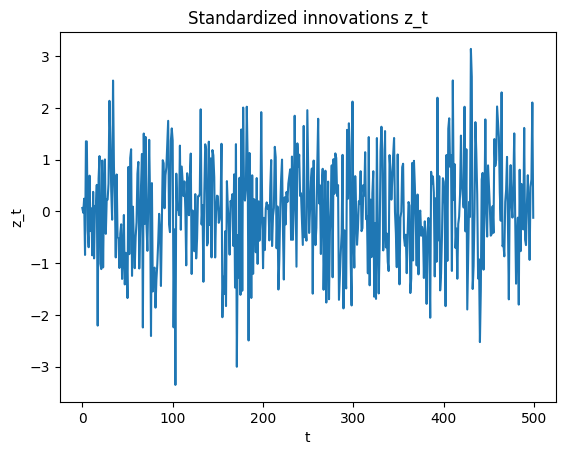

In [3]:

# Synthetic stationary parameters (should converge)
T=500
k=2
true_theta = np.array([0.6, -0.2])
X = np.random.randn(T, k)
y = X @ true_theta + 0.1*np.random.randn(T)

kf = create_discounted_kalman(k=k, R=0.01, delta=0.98)

thetas = np.zeros((T,k))
zs = np.zeros(T)
Ss = np.zeros(T)

for t in range(T):
    z,S,theta = kf.step(X[t], y[t])
    thetas[t]=theta
    zs[t]=z; Ss[t]=S

# Plot parameter learning
plt.figure()
plt.plot(thetas[:,0], label='theta1')
plt.plot(thetas[:,1], label='theta2')
plt.axhline(true_theta[0], linestyle='--')
plt.axhline(true_theta[1], linestyle='--')
plt.title('Parameter Estimates over Time')
plt.xlabel('t'); plt.ylabel('value')
plt.legend(); plt.show()

# Plot standardized innovations (should look ~N(0,1) if well-specified)
plt.figure()
plt.plot(zs)
plt.title('Standardized innovations z_t')
plt.xlabel('t'); plt.ylabel('z_t')
plt.show()


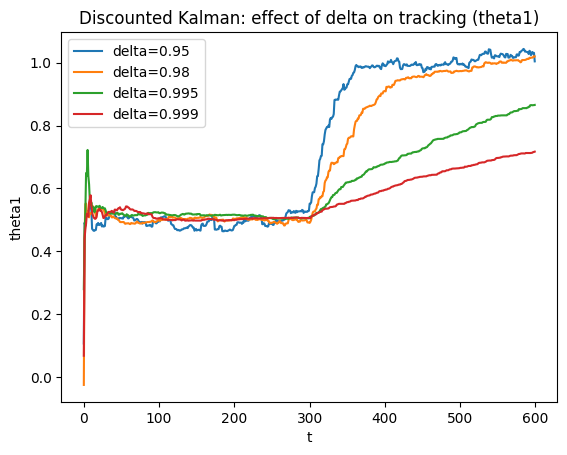

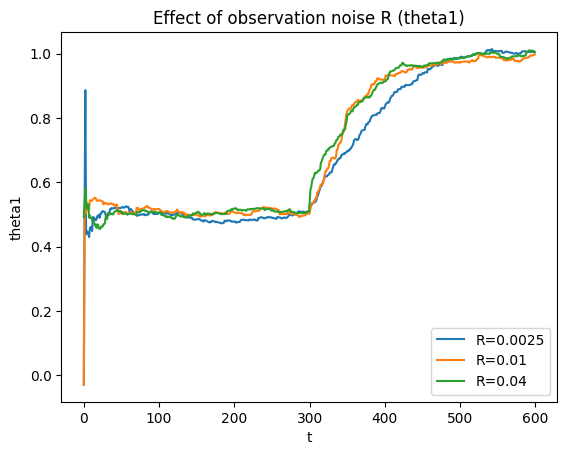

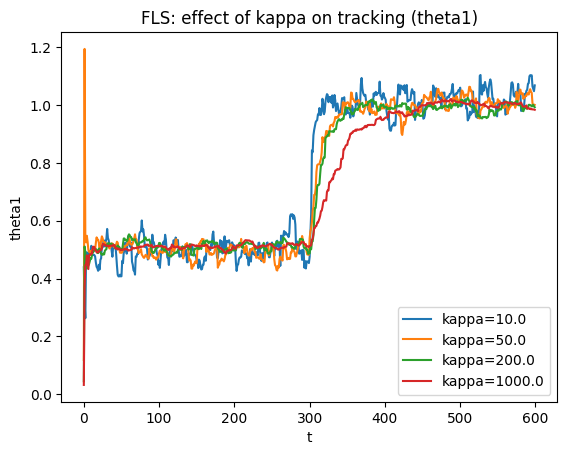

In [4]:


def run_filter(delta=0.98, R=0.01, mode="discount", kappa=100.0, jump=False):
    T=600; k=2
    theta0 = np.array([0.5,-0.3])
    X = np.random.randn(T,k)
    theta_path = np.repeat(theta0[None,:], T, axis=0)
    if jump:
        theta_path[300:] += np.array([0.5, -0.2])
    y = np.sum(X*theta_path, axis=1) + 0.1*np.random.randn(T)

    if mode=="discount":
        kf = create_discounted_kalman(k=k, R=R, delta=delta)
    else:
        kf = create_fls_kalman(k=k, R=R, kappa=kappa)

    thetas = np.zeros((T,k)); zs=np.zeros(T)
    for t in range(T):
        z,S,theta = kf.step(X[t], y[t])
        thetas[t]=theta; zs[t]=z
    return thetas, zs, theta_path

# Compare deltas
plt.figure()
for d in [0.95, 0.98, 0.995, 0.999]:
    thetas, zs, theta_path = run_filter(delta=d, R=0.01, mode="discount", jump=True)
    plt.plot(thetas[:,0], label=f'delta={d}')
plt.title('Discounted Kalman: effect of delta on tracking (theta1)'); plt.xlabel('t'); plt.ylabel('theta1')
plt.legend(); plt.show()

# Compare R
plt.figure()
for R in [0.0025, 0.01, 0.04]:
    thetas, zs, theta_path = run_filter(delta=0.98, R=R, mode="discount", jump=True)
    plt.plot(thetas[:,0], label=f'R={R}')
plt.title('Effect of observation noise R (theta1)'); plt.xlabel('t'); plt.ylabel('theta1')
plt.legend(); plt.show()

# Compare FLS kappa
plt.figure()
for kappa in [10.0, 50.0, 200.0, 1000.0]:
    thetas, zs, theta_path = run_filter(mode="fls", kappa=kappa, jump=True)
    plt.plot(thetas[:,0], label=f'kappa={kappa}')
plt.title('FLS: effect of kappa on tracking (theta1)'); plt.xlabel('t'); plt.ylabel('theta1')
plt.legend(); plt.show()


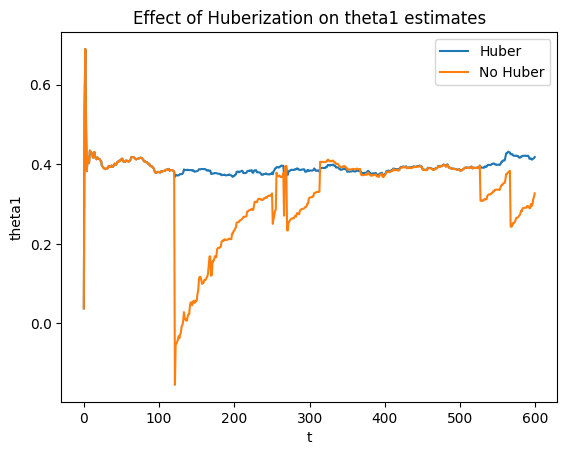

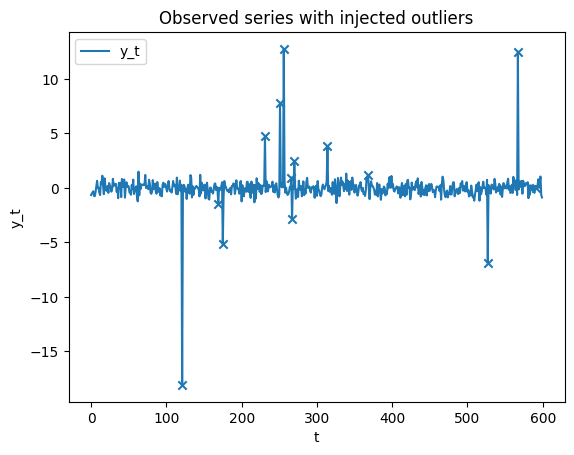

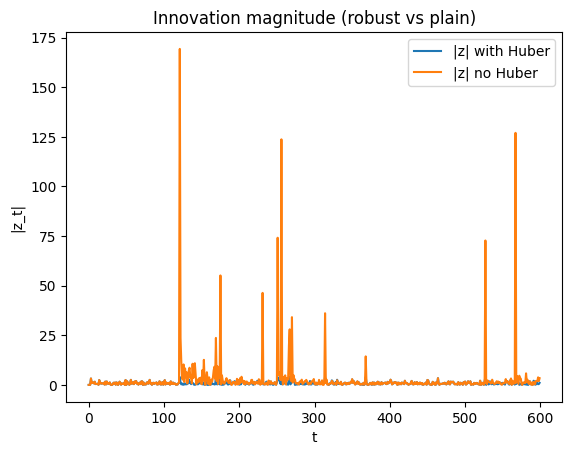

In [5]:

def make_outlier_series(T=600, k=2, p_outlier=0.02, outlier_scale=10.0):
    theta = np.array([0.4, -0.25])
    X = np.random.randn(T,k)
    base = X @ theta + 0.1*np.random.randn(T)
    mask = np.random.rand(T) < p_outlier
    y = base.copy()
    y[mask] += outlier_scale*np.random.randn(mask.sum())
    return X, y, theta, mask

def run(R=0.01, delta=0.98, huber_c=4.0):
    k=2
    kf_huber = TVPKalman(k=k, F=np.eye(k), R=R, delta=delta, huber_c=huber_c, mode="discount")
    kf_basic = TVPKalman(k=k, F=np.eye(k), R=R, delta=delta, huber_c=1e9, mode="discount")  # effectively no clipping
    X,y,theta_true,mask = make_outlier_series()

    T=len(y)
    th_h = np.zeros((T,k)); zh=np.zeros(T)
    th_b = np.zeros((T,k)); zb=np.zeros(T)

    for t in range(T):
        zH,_,th = kf_huber.step(X[t], y[t]); th_h[t]=th; zh[t]=zH
        zB,_,tb = kf_basic.step(X[t], y[t]); th_b[t]=tb; zb[t]=zB

    return X,y,theta_true,mask,th_h,th_b,zh,zb

X,y,theta_true,mask,th_h,th_b,zh,zb = run()

# Plot theta1 estimates with/without Huber
plt.figure()
plt.plot(th_h[:,0], label='Huber')
plt.plot(th_b[:,0], label='No Huber')
plt.title('Effect of Huberization on theta1 estimates')
plt.xlabel('t'); plt.ylabel('theta1'); plt.legend(); plt.show()

# Plot where outliers occurred
plt.figure()
plt.plot(y, label='y_t')
plt.scatter(np.where(mask)[0], y[mask], marker='x')
plt.title('Observed series with injected outliers')
plt.xlabel('t'); plt.ylabel('y_t'); plt.legend(); plt.show()

# Plot standardized innovation magnitude comparison
plt.figure()
plt.plot(np.abs(zh), label='|z| with Huber')
plt.plot(np.abs(zb), label='|z| no Huber')
plt.title('Innovation magnitude (robust vs plain)')
plt.xlabel('t'); plt.ylabel('|z_t|'); plt.legend(); plt.show()


Change Points

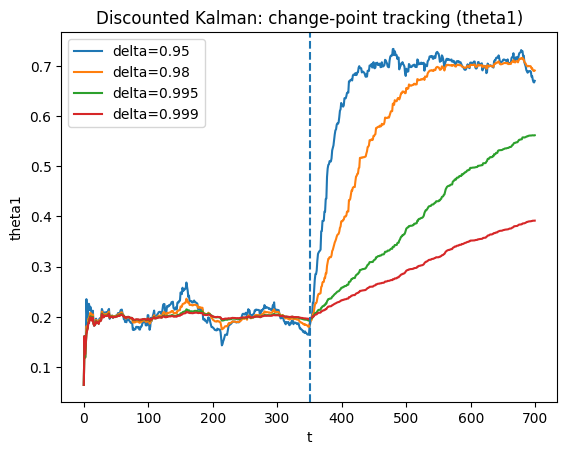

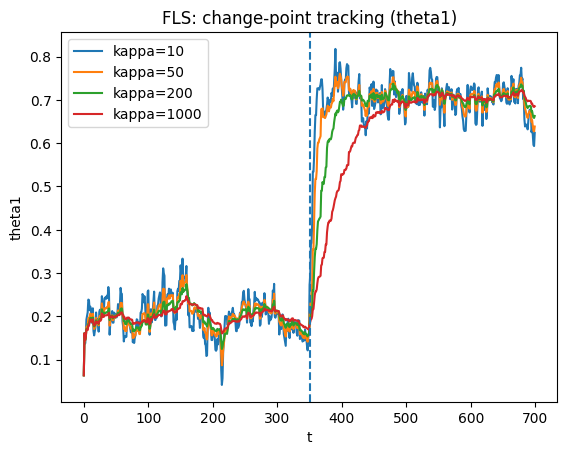

In [6]:


def simulate_jump(T=700, k=2):
    X = np.random.randn(T,k)
    theta = np.zeros((T,k))
    theta[:350] = np.array([0.2,-0.2])
    theta[350:] = np.array([0.7,-0.4])
    y = np.sum(X*theta, axis=1) + 0.1*np.random.randn(T)
    return X,y,theta

X,y,theta_path = simulate_jump()

def track(mode, param):
    k=2
    if mode=="discount":
        kf = create_discounted_kalman(k=k, R=0.01, delta=param)
    else:
        kf = create_fls_kalman(k=k, R=0.01, kappa=param)
    T=len(y); th=np.zeros((T,k))
    for t in range(T):
        _,_,theta = kf.step(X[t], y[t])
        th[t]=theta
    return th

plt.figure()
for d in [0.95, 0.98, 0.995, 0.999]:
    th = track("discount", d)
    plt.plot(th[:,0], label=f'delta={d}')
plt.axvline(350, linestyle='--')
plt.title('Discounted Kalman: change-point tracking (theta1)')
plt.xlabel('t'); plt.ylabel('theta1'); plt.legend(); plt.show()

plt.figure()
for kappa in [10, 50, 200, 1000]:
    th = track("fls", kappa)
    plt.plot(th[:,0], label=f'kappa={kappa}')
plt.axvline(350, linestyle='--')
plt.title('FLS: change-point tracking (theta1)')
plt.xlabel('t'); plt.ylabel('theta1'); plt.legend(); plt.show()
